In [1]:
import utils

In [2]:
from src.NN.KerasMultiHead import MultiHeadModel
from src.Data.IMULocationDataset import IMULocationDataset
from src.Data.MergedIMULocationDataset import MergedIMULocationDataset
from whar_datasets import WHARDatasetID
from src.NN.Arch.ClassifierHead import *
from src.NN.Arch.ReconstructionHead import *
from src.NN.Arch.Encoder import *
from src.Data.SensorTypes import SensorLocation

import numpy as np

2026-01-10 11:33:38.760485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/king/Github/TinyHARFoundation/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


++++++ Global class name mapping:
0: Stand-sit
1: car_driving
2: clean_table
3: close_dishwasher
4: close_door
5: close_drawer
6: close_fridge
7: computer_work
8: cycling
9: cycling_on_exercise_bike_horizontal
10: cycling_on_exercise_bike_vertical
11: drinking
12: exercise_cross_trainer
13: exercise_stepper
14: folding_laundry
15: frontal_elevation_of_arms
16: house_cleaning
17: ironing
18: jogging
19: jump_front_and_back
20: jumping
21: knees_bending_crouching
22: laying
23: laying_standing
24: moving_around_in_an_elevator
25: nordic_walking
26: null
27: open_dishwasher
28: open_door
29: open_drawer
30: open_fridge
31: picking
32: playing_basketball
33: playing_soccer
34: push_up
35: rope_jumping
36: rowing
37: running
38: running_threadmill
39: sit_up
40: sitting
41: stair_down
42: stair_up
43: standing
44: standing_in_an_elevator_still
45: table_tennis
46: talking_sitting
47: talking_standing
48: toggle_switch
49: unknown
50: vacuum_cleaning
51: waist_bends_forward
52: walking
53: w

In [3]:
mhealth = IMULocationDataset(WHARDatasetID.MHEALTH)
dsads = IMULocationDataset(WHARDatasetID.DSADS)
pamap2 = IMULocationDataset(WHARDatasetID.PAMAP2)

Loaded IMU Location Dataset from cache.
Loaded IMU Location Dataset from cache.
Loaded IMU Location Dataset from cache.


In [4]:
merged_dataset = MergedIMULocationDataset([mhealth, dsads], locations=[SensorLocation.ARMS])

In [5]:
merged_dataset.train.samples.shape
ds_slice = merged_dataset.train.samples[0:5, :, :]

print(np.unique(merged_dataset.train.labels))

[ 8  9 10 12 13 15 18 19 20 21 22 24 26 32 36 37 38 40 43 44 51 52 55 56
 57]


In [8]:
from keras.models import Model
import tensorflow as tf
from keras import layers as L


backbone = build_transformer_backbone_seq(ts_len=merged_dataset.train.samples.shape[1])
classifier_head = build_classifier_head(num_classes=merged_dataset.num_classes, channels=backbone.output_shape[-1])
backbone(ds_slice).shape
print("Backbone parameters:", backbone.count_params())
print("Classifier head parameters:", classifier_head.count_params())

multi_head = MultiHeadModel(backbone)
multi_head.add_head("classifier", classifier_head)
multi_head(ds_slice)["classifier"].shape

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={"classifier": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]},
)

history = multi_head.fit(x=merged_dataset.train.samples, y={"classifier": merged_dataset.train.labels}, epochs=5, verbose=1)

Backbone parameters: 71346
Classifier head parameters: 3835
Epoch 1/5
   8/1275 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - acc: 0.0403 - loss: 3.8934         

2026-01-10 11:37:42.435472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_1', 200 bytes spill stores, 156 bytes spill loads



1275/1275 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - acc: 0.5426 - loss: 1.4929
Epoch 2/5
   1/1275 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - acc: 0.6250 - loss: 1.2004

2026-01-10 11:38:01.409337: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_2', 140 bytes spill stores, 120 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_1', 44 bytes spill stores, 28 bytes spill loads



1275/1275 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.6758 - loss: 0.9603
Epoch 3/5
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.7201 - loss: 0.8223
Epoch 4/5
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.7469 - loss: 0.7358
Epoch 5/5
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.7699 - loss: 0.6668


In [ ]:
# def build_classifier_head(num_classes):
#     z_in = tf.keras.Input(shape=(128,), name="embedding")
#     x = L.Dense(64, activation="swish", name="clf_dense1")(z_in)
#     x = L.Dropout(0.3, name="clf_do1")(x)
#     x = L.Dense(num_classes, activation="softmax", name="clf_out")(x)
#     return tf.keras.Model(z_in, x, name="classifier_head")

# classifier_head = build_classifier_head(num_classes=dataset.num_classes)

In [10]:
from src.Data.Preprocessing import make_masked_reconstruction_ds

# backbone = build_conv_backbone_seq(ts_len=merged_dataset.train.samples.shape[1])
backbone = build_transformer_backbone_seq(ts_len=merged_dataset.train.samples.shape[1])
reconstruction_head = build_reconstruction_head()
multi_head = MultiHeadModel(backbone)
multi_head.add_head("reconstruction", reconstruction_head)

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
    loss={"reconstruction": tf.keras.losses.MeanSquaredError()},
)

train_ds = make_masked_reconstruction_ds(merged_dataset.train.samples, batch_size=64, mask_ratio=0.2)
val_ds   = make_masked_reconstruction_ds(merged_dataset.val.samples,   batch_size=64, mask_ratio=0.2, shuffle=0)

multi_head.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)

Epoch 1/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1551

2026-01-10 11:40:44.451935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_3', 140 bytes spill stores, 120 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_2', 44 bytes spill stores, 28 bytes spill loads



638/638 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.1336 - val_loss: 0.1177
Epoch 2/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1199 - val_loss: 0.1158
Epoch 3/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1180 - val_loss: 0.1139
Epoch 4/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1169 - val_loss: 0.1126
Epoch 5/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1161 - val_loss: 0.1123
Epoch 6/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1153 - val_loss: 0.1109
Epoch 7/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1146 - val_loss: 0.1102
Epoch 8/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1141 - val_loss: 0.1106
Epoch 9/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1137 - val_loss: 0.1099
Epoch 10/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1137 - val_loss: 0.1091
Epoch 11/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1131 - val_loss: 0.1093
Epoch 12/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/st

In [11]:
multi_head.backbone.save("pretrained_backbone.keras")

In [12]:
fine_tune_dataset = MergedIMULocationDataset([dsads, mhealth], locations=[SensorLocation.ARMS], ratio=0.1)

In [13]:
import keras

classifier_head = build_classifier_head(
    num_classes=merged_dataset.num_classes,
    channels=multi_head.backbone.output_shape[-1],
)

multi_head = MultiHeadModel(keras.models.load_model("pretrained_backbone.keras"))


multi_head.add_head("classifier", classifier_head)
multi_head.backbone.trainable = False

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={"classifier": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]},
)

history = multi_head.fit(
    x=fine_tune_dataset.train.samples,
    y={"classifier": fine_tune_dataset.train.labels},
    validation_data=(fine_tune_dataset.val.samples, {"classifier": fine_tune_dataset.val.labels}),
    epochs=20,
    verbose=1,
)

Epoch 1/20


2026-01-10 11:45:12.195906: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_1', 200 bytes spill stores, 156 bytes spill loads



KeyboardInterrupt: 

In [ ]:
from src.Visualization.tsne import tsne, plot_tsne
import numpy as np
import keras
backbone = keras.models.load_model("pretrained_backbone.keras")

# If your backbone outputs (N,T,C), pool to (N,C) first:
feat = backbone.predict(merged_dataset.train.samples, batch_size=32, verbose=1)   # (N,T,C)
E = feat.mean(axis=1)
print(E.shape)

# res = tsne(E, perplexity=30, random_state=0)
# plot_tsne(res.xy, labels=merged_dataset.val.labels, title="Backbone embeddings (val)")


1275/1275 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


2026-01-09 16:06:17.425886: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2672558080 exceeds 10% of free system memory.


(40780, 128)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


2026-01-09 16:17:52.211665: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 327680000 exceeds 10% of free system memory.


(5000, 128)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.372251
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.895996
[t-SNE] KL divergence after 1000 iterations: 1.342210


(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Backbone embeddings (train)'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>)

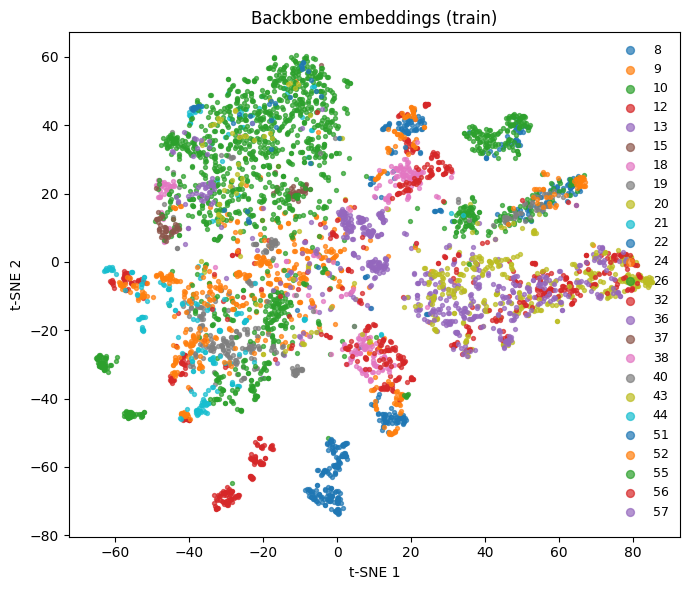

In [ ]:
# Choose 1000 samples for t-SNE visualization
num_samples = 5000
indices = np.random.choice(merged_dataset.train.samples.shape[0], num_samples, replace=False)
sampled_samples = merged_dataset.train.samples[indices]
sampled_labels = merged_dataset.train.labels[indices]
feat = backbone.predict(sampled_samples, batch_size=32, verbose=1)   # (N,T,C)
E = feat.mean(axis=1)
print(E.shape)

res = tsne(E, perplexity=30, random_state=0)
plot_tsne(res.xy, labels=sampled_labels, title="Backbone embeddings (train)")